# Billables Diff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
import os
import re
from matplotlib.ticker import LogFormatterSciNotation, LogLocator, NullLocator, SymmetricalLogLocator, FixedLocator
import gc

In [2]:
print("="*80)
print("Billables Diff")
print("-"*80)

Billables Diff
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Traces

In [4]:
# Get trace data dir from CURRENT_DIR/../data.env
with open( '../data.env') as f:
    for line in f:
        if line.startswith('TRACE_DATA_DIR'):
            TRACE_DATA_DIR = line.split('=')[1].strip()
            break
REQUEST_TRACES_PATH = os.path.join(TRACE_DATA_DIR, 'public_request_tables')
COLDSTART_TRACES_PATH = os.path.join(TRACE_DATA_DIR, 'public_cold_starts')

In [5]:
REQUEST_TRACES_PATH = os.path.join(REQUEST_TRACES_PATH, 'huawei_25_traces_request_usage_rt.pkl')
COLDSTART_TRACES_PATH = os.path.join(COLDSTART_TRACES_PATH, 'huawei_25_traces_public_cold_starts.pkl')

In [6]:
print("Loading request traces...")
with open(REQUEST_TRACES_PATH, "rb") as f:
    request_traces = pickle.load(f)
    
print("Loading cold start traces...")
with open(COLDSTART_TRACES_PATH, "rb") as f:
    coldstart_traces = pickle.load(f)

Loading request traces...
Loading cold start traces...


In [7]:
print("Request traces:", request_traces.shape)
print("Cold start traces:", coldstart_traces.shape)

Request traces: (947970744, 4)
Cold start traces: (11913857, 14)


In [8]:
request_traces.head()

,podID,runtimeCost,cpu_usage,memory_usage
0,pool24-600-512-0004546402,0.058268,0.600000,313.187500
1,pool22-300-128-0003702527,0.334085,0.098253,49.406250
2,pool26-1000-1024-0001996304,0.183630,0.174525,51.027344
3,pool24-600-512-0006653892,0.047347,0.433650,307.187500
4,pool22-300-128-0004007403,0.184775,0.152065,45.281250


In [9]:
coldstart_traces.head()

,day,time,clusterName,funcName,userID,requestID,totalCost_cold_start,podAllocationCost,deployCodeCost,deployDependencyCost,schedulingCost,podID,cpu_cores,memory_mb
0,9,777600.021,2,817,274,514e6fd088fcf2107be15af772f2bd41599d4eba2e650f...,3.591384,0.021593,1.279,0.0,2.290791,pool24-600-512-0003012116,0.6,512
1,9,777600.261,2,462,431,370d04bf0e14a4e773e2b5e04a6a5edcb9abf4d85b21f5...,0.213559,0.000765,0.002,0.0,0.210794,pool22-300-128-0005673850,0.3,128
2,9,777600.329,1,1145,421,3971b40a9c0c2c39711ba6addca16d0106e4a778ddf9d1...,0.677392,0.015221,0.622,0.0,0.040171,pool22-300-128-0001906247,0.3,128
3,9,777600.343,4,2028,197,ee033cc5912fd8493c08e377dbec136b6349434238fcac...,2.324909,0.020523,1.651,0.0,0.653386,pool30-1800-2048-0001446829,1.8,2048
4,9,777600.525,4,1365,602,c2d685a2a59e655665e258091db2af5e53933ce3fca566...,5.236194,0.019833,1.604,0.0,3.612361,pool26-1000-1024-0005731082,1.0,1024


In [10]:
coldstart_traces['on_user_cold_start_time_ms'] = coldstart_traces['deployCodeCost'] * 1000 + coldstart_traces['deployDependencyCost'] * 1000

In [11]:
coldstart_traces.head()

,day,time,clusterName,funcName,userID,requestID,totalCost_cold_start,podAllocationCost,deployCodeCost,deployDependencyCost,schedulingCost,podID,cpu_cores,memory_mb,on_user_cold_start_time_ms
0,9,777600.021,2,817,274,514e6fd088fcf2107be15af772f2bd41599d4eba2e650f...,3.591384,0.021593,1.279,0.0,2.290791,pool24-600-512-0003012116,0.6,512,1279.0
1,9,777600.261,2,462,431,370d04bf0e14a4e773e2b5e04a6a5edcb9abf4d85b21f5...,0.213559,0.000765,0.002,0.0,0.210794,pool22-300-128-0005673850,0.3,128,2.0
2,9,777600.329,1,1145,421,3971b40a9c0c2c39711ba6addca16d0106e4a778ddf9d1...,0.677392,0.015221,0.622,0.0,0.040171,pool22-300-128-0001906247,0.3,128,622.0
3,9,777600.343,4,2028,197,ee033cc5912fd8493c08e377dbec136b6349434238fcac...,2.324909,0.020523,1.651,0.0,0.653386,pool30-1800-2048-0001446829,1.8,2048,1651.0
4,9,777600.525,4,1365,602,c2d685a2a59e655665e258091db2af5e53933ce3fca566...,5.236194,0.019833,1.604,0.0,3.612361,pool26-1000-1024-0005731082,1.0,1024,1604.0


In [12]:
coldstart_traces.columns

Index(['day', 'time', 'clusterName', 'funcName', 'userID', 'requestID',
       'totalCost_cold_start', 'podAllocationCost', 'deployCodeCost',
       'deployDependencyCost', 'schedulingCost', 'podID', 'cpu_cores',
       'memory_mb', 'on_user_cold_start_time_ms'],
      dtype='object')

## Release

In [13]:
execution_duration_data = request_traces[['podID', 'runtimeCost']].copy()
del request_traces
gc.collect() # reduce the memory footprint of this analysis code

0

In [14]:
def convert_to_hashmap(data):
    hashmap = {}
    for funcName, group in data.groupby('podID'):
        hashmap[funcName] = group
    return hashmap
execution_duration_hashmap = convert_to_hashmap(execution_duration_data)

### Caclulate Billable Resources

In [15]:
resource_usage_cpu_diffs = []
resource_usage_mem_diffs = []
on_user_cold_start_latency_ms = []

for index, row in coldstart_traces.iterrows():
    podID = row['podID']
    if podID not in execution_duration_hashmap:
        continue
    on_user_cold_start_latency_ms.append(row['on_user_cold_start_time_ms'])
    execution_duration_df = execution_duration_hashmap[podID]

    total_execution_duration_ms = execution_duration_df['runtimeCost'].sum() * 1000
    wall_time_diff = total_execution_duration_ms - row['on_user_cold_start_time_ms'] 

    cpu_diff = wall_time_diff * row['cpu_cores'] # vcpu-ms
    mem_diff = wall_time_diff * row['memory_mb'] # mb * ms

    resource_usage_cpu_diffs.append(cpu_diff)
    resource_usage_mem_diffs.append(mem_diff)



In [16]:
billables_diff = {
    "cpu": resource_usage_cpu_diffs,
    "memory": resource_usage_mem_diffs
}

In [17]:
processed_data_dir = os.path.join(TRACE_DATA_DIR, 'processed_data')
os.makedirs(processed_data_dir, exist_ok=True)
processed_data_path = os.path.join(processed_data_dir, 'billables_diff.pkl')

In [18]:
# dump to pickle
with open(processed_data_path, "wb") as f:
    pickle.dump(billables_diff, f)

In [19]:
# load from pickle
# with open(processed_data_path, "rb") as f:
#     billables_diff = pickle.load(f)
resource_usage_cpu_diffs = billables_diff["cpu"]
resource_usage_mem_diffs = billables_diff["memory"]

In [20]:
resource_usage_cpu_diffs_vcpu_sec = np.array(resource_usage_cpu_diffs) / 1000 # convert to vcpu-sec
resource_usage_mem_diffs_gb_sec = np.array(resource_usage_mem_diffs) / 1024 / 1000 # convert to gb-sec

In [21]:
len(resource_usage_mem_diffs_gb_sec)

388955

## Plotting

### Billable Resources Diff

Figure saved to figures/billable_resource_diffs.pdf


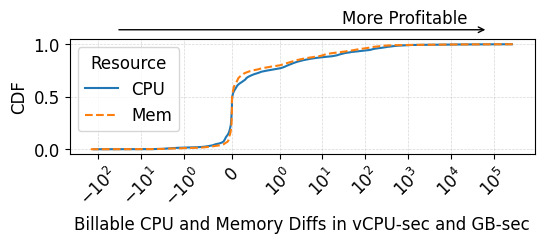

In [22]:
fig, ax = plt.subplots(figsize=(6, 1.5))

s = np.sort(resource_usage_cpu_diffs_vcpu_sec)
cdf = np.arange(1, s.size + 1) / s.size
ax.plot(s, cdf, label="CPU")

s = np.sort(resource_usage_mem_diffs_gb_sec)
cdf = np.arange(1, s.size + 1) / s.size
ax.plot(s, cdf, label="Mem", linestyle='--')

ax.set_xlabel('Billable CPU and Memory Diffs in vCPU-sec and GB-sec', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)
ax.legend(title="Resource", fontsize=12, title_fontsize=12, bbox_to_anchor=(0, 1), loc='upper left')

# Use symlog for x-axis
ax.set_xscale('symlog', linthresh=1.0, linscale=1.0)
ax.grid(alpha=0.5, linestyle='--', linewidth=0.5)

# scientific notation
from matplotlib.ticker import LogFormatterSciNotation
ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10))
ax.xaxis.set_minor_formatter(LogFormatterSciNotation(base=10))
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# ←– Arrow and label showing 'more profitable' to the right
ax.annotate(
    '',
    xy=(0.9, 1.08),
    xytext=(0.1, 1.08),
    xycoords='axes fraction',
    arrowprops=dict(arrowstyle='->', lw=1)
)
ax.text(
    0.72, 1.1,
    'More Profitable',
    transform=ax.transAxes,
    ha='center',
    va='bottom',
    fontsize=12
)

plt.savefig('figures/billable_resource_diffs.pdf', bbox_inches='tight')
print("Figure saved to figures/billable_resource_diffs.pdf")


In [23]:
print("p42.1 Billable CPU Diffs in vCPU-seconds:", np.percentile(resource_usage_cpu_diffs_vcpu_sec, 42.1))
print("p42.1 Billable Memory Diffs in GB-seconds:", np.percentile(resource_usage_mem_diffs_gb_sec, 42.1))
print("p42.2 Billable CPU Diffs in vCPU-seconds:", np.percentile(resource_usage_cpu_diffs_vcpu_sec, 42.2))
print("p42.2 Billable Memory Diffs in GB-seconds:", np.percentile(resource_usage_mem_diffs_gb_sec, 42.2))

print(f"The results show that 42.1% of cold starts produce a zero or negative difference.")

p42.1 Billable CPU Diffs in vCPU-seconds: 0.0
p42.1 Billable Memory Diffs in GB-seconds: 0.0
p42.2 Billable CPU Diffs in vCPU-seconds: 8.699999999999973e-06
p42.2 Billable Memory Diffs in GB-seconds: 3.7500000000000035e-06
The results show that 42.1% of cold starts produce a zero or negative difference.
